In [0]:
%%capture
!pip install turicreate
!pip install kneed

import kneed
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import pairwise_distances_argmin_min
import tensorflow as tf
import tensorflow_hub as hub

In [0]:
IMG_WIDTH = IMG_HEIGHT = 224

def decode_img(file_path):
  img = tf.io.read_file(file_path)
  img = tf.image.decode_jpeg(img, channels=3)
  # img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])
  img = tf.expand_dims(img, 0)
  return img

In [0]:
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4" 
model = hub.load(MODEL_URL)

In [0]:
ICELAND_IMAGES_ROOT = './drive/My Drive/Iceland'

# There's a subdirectory named 'heic'
image_file_paths = [
  os.path.join(ICELAND_IMAGES_ROOT, item) 
  for item in os.listdir(ICELAND_IMAGES_ROOT) 
  if item != 'heic'
]

image_feature_vectors = []
for index, path in enumerate(image_file_paths):
  print("{}/{}".format(index + 1, len(image_file_paths)))
  image_feature_vectors.append(np.squeeze(model(decode_img(path))).tolist())

In [0]:
image_file_paths = np.array(image_file_paths)
image_feature_vectors = np.array(image_feature_vectors)

In [0]:
kmeans_model = KMeans(n_clusters = 600).fit(image_feature_vectors)

In [0]:
medoid_indices, _ = pairwise_distances_argmin_min(kmeans_model.cluster_centers_, image_feature_vectors)
medoid_images = image_file_paths[medoid_indices]

['./drive/My Drive/Iceland/IMG_9139.jpg', './drive/My Drive/Iceland/IMG_0551.jpg', './drive/My Drive/Iceland/IMG_9392.jpg', './drive/My Drive/Iceland/IMG_20190430_155910.jpg', './drive/My Drive/Iceland/IMG_6119.jpg', './drive/My Drive/Iceland/IMG_6181.jpg', './drive/My Drive/Iceland/IMG_6184.jpg', './drive/My Drive/Iceland/IMG_6183.jpg', './drive/My Drive/Iceland/IMG_6182.jpg', './drive/My Drive/Iceland/IMG_6180.jpg', './drive/My Drive/Iceland/IMG_6179.jpg']


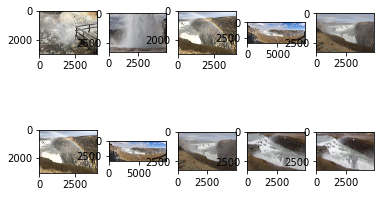

In [66]:
import random
RAND_LABEL = random.randint(min(kmeans_model.labels_), max(kmeans_model.labels_))

like_imgs = []

for index, label in enumerate(kmeans_model.labels_):
  if label == RAND_LABEL:
    like_imgs.append(image_file_paths[index])

print(like_imgs)

n_rows = 2
for i in reversed(range(2, int(np.sqrt(len(like_imgs))) + 1)):
  if len(like_imgs) % i == 0:
    n_rows = i
    break

n_cols = len(like_imgs) // n_rows

fig, axs = plt.subplots(n_rows, n_cols)
for i in range(n_rows):
  for j in range(n_cols):
    img = mpimg.imread(like_imgs[n_rows * i + j])
    axs[i, j].imshow(img)

fig.show()

In [0]:
def calculate_WSS(points, kmin, kmax, step = 1):
  sse = []
  for k in range(kmin, kmax+1, step):
    print('{}/{}'.format(k, kmax))
    kmeans = KMeans(n_clusters = k).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(points)):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
  return sse